# Fitting Laplace equation

11.6 $\mu$m-sized droplet making a contact angle of 140$^{\circ}$ on the AFM cantilever.

Volume of the spherical cap is given by

\begin{equation*}
V = \frac{\pi}{3} R^3 (2 + \cos \theta) (1-\cos \theta)^2
\end{equation*}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pandas as pd
import seaborn as sns
from scipy import interpolate

import warnings
warnings.filterwarnings('ignore')

sns.set_style("ticks")
color_b = sns.xkcd_rgb["marine"]

theta = 140
cos_t = np.cos(theta/180*np.pi) # contact angle

R_ = (11.6/2)*1e-6 # um

r_ = R_*np.sin(theta/180*np.pi)

V_ = np.pi/3*R_**3*(2+cos_t)*(1-cos_t)**2

print ("Contact size on cantilever is {:e} m".format(2*r_))
print ("Droplet volume is {:e} m^3".format(V_)) 

H_init = (1-cos_t)*R_
print ("Initial height is {:e} m".format(H_init))

Contact size on cantilever is 7.456336e-06 m
Droplet volume is 7.863491e-16 m^3
Initial height is 1.024306e-05 m


Reading text file containing force spectroscopy measurements

In [2]:
file_name = 'droplet.txt'

col_names = ["Vertical Tip Position", "Vertical Deflection", "Precision 5", "Height",
             "Height (measured & smoothed)", "Height (measured)", "Series Time", "Segment Time"]

df = pd.read_csv(file_name, comment='#', sep=' ', names = col_names)

x1 = df["Vertical Tip Position"]
x1 = x1 + 0.1*1e-6
y1 = df["Vertical Deflection"]*1e9 # nN
t = df["Series Time"]
h = df["Height (measured)"]

i_start = 0
i_end  = 500000

i_turn = np.where(h == np.amin(h))[0][0]

i_skip = 1

x1_approach = x1[i_start:i_turn:i_skip]*1e6
y1_approach = y1[i_start:i_turn:i_skip]
x1_retract = x1[i_turn:i_end:i_skip]*1e6
y1_retract = y1[i_turn:i_end:i_skip]

x_shift_approach = 0
x1_approach = x1_approach.values-x_shift_approach
y1_approach = y1_approach.values

x_shift_retract = 0
x1_retract = x1_retract-x_shift_retract

# Fitting force curve

<img src="Force_angle_only.png" style="width:400px"/>

## Solving non-dimensionalized Laplace equation

Following the approach of Butt et al, Curr. Opin. Colloid Interface Sci. 19, 343-354 (2014), we non-dimensionalize the variables by $a$ and $\gamma$, i.e.

\begin{align}
\hat{F} &=  F \gamma^{-1} a^{-1} \\
\hat{r} &=  r a^{-1} \\
\hat{V} &=  V a^{-3} \\
\Delta \hat{P} &=  \Delta P a \gamma^{-1},\mathrm{etc}
\end{align}

and hence, we get the non-dimensionalized Young-Laplace equation

\begin{align}
\frac{\hat{u}''}{(1+\hat{u}'^{2})^{3/2}} - \frac{1}{\hat{u}\sqrt{1 + \hat{u}'^{2}}}
&= -\Delta \hat{P} \; \mathrm{for} \; \hat{z} \in (0, \hat{h}) \\
\end{align}

subject to the boundary conditions

\begin{align}
\hat{u}(0) &= \hat{r} \\
\hat{u}(\hat{h}) &= 1 \\
\int_{0}^{h} \pi \hat{u}^{2}d\hat{z} &= \hat{V} \\
\end{align}

and 

\begin{align}
F &= -\frac{2 \pi \hat{r}}{\sqrt{1 + \hat{u}'(0)^{2}}} + \pi r^{2}\Delta P.  
\end{align}

Using the shooting method, we chose to frame the Young-Laplace equation as an initial value problem, with initial values

\begin{align}
\hat{u}(0) &= \hat{r} \\
\hat{u}'(0) &= -\cot \theta,
\end{align}

while requiring that

$$\mathbf{\hat{m}}(\hat{r}, \Delta \hat{P}, \theta) =
\begin{pmatrix} \hat{u}(\hat{h})- 1 \\ 
\int_{0}^{\hat{h}} \pi \hat{u}^{2}d\hat{z} - \hat{V}\\
\hat{F} + 2 \pi \gamma \hat{r} \sin \theta - \pi \hat{r}^{2}\Delta \hat{P}
 \end{pmatrix} = 0$$.

This converts the boundary value problem into a root-finding problem of $\mathbf{\hat{m}}=0$, as implemented below

# Results

In [3]:
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.optimize import newton, fsolve
from scipy.integrate import simps

n_point = 100  # number of points to plot droplet profile

def ode(u, z):
    return np.array([u[1], (1+u[1]**2)**(1.5)*(1/(u[0]*np.sqrt(1+u[1]**2)) - u[2]), 0])  

# Calculate the residue 
def m_res(x, h_f, F_exp):
    
    r = x[0]
    dP = x[1]
    theta = x[2]
    
    z_arr = np.linspace(0, h_f, n_point)

    y_start = np.array([r, -1/np.tan(theta), dP])
    sol = odeint(ode, y_start, z_arr, atol=1e-7)
#     sol = solve_ivp(ode, z_arr, y_start, atol=1e-11)

    u_arr = sol[:,0]
    dP_arr = sol[:,2]
    u_arr_1 = u_arr[dP_arr == dP]
    z_arr_1 = z_arr[dP_arr == dP]
    V_int = simps(np.pi*u_arr_1**2, z_arr_1)
    
    u_h = u_arr[-1]
    
    
    F = 2*np.pi*r*np.sin(theta) - dP*np.pi*r**2
    return np.array([1-u_h, V_norm-V_int, F-F_exp])
        
    
def calculate_sol(x, hf):
    r = x[0]
    dP = x[1]
    theta = x[2]
    
    z_arr = np.linspace(0, hf, n_point)

    y_start = np.array([r, -1/np.tan(theta), dP])
    sol = odeint(ode, y_start, z_arr, atol=1e-7)
#     sol = solve_ivp(ode, z_arr, y_start, atol=1e-11)

    u_arr = sol[:,0]
    dP_arr = sol[:,2]
    u_arr_1 = u_arr[dP_arr == dP]
    z_arr_1 = z_arr[dP_arr == dP]
    V_int = simps(np.pi*u_arr_1**2, z_arr_1)
    
    F_sol = 2*np.pi*r*np.sin(theta) - dP*np.pi*r**2
    
    return z_arr, u_arr, dP, V_int, F_sol

1.0243057770090071e-05 9.403704300090071
[ 3.12116999e-12  5.51416690e-11 -4.40050774e-13]
Contact size is 6.6 um
Contact angle is 144.7 deg
Pressure inside droplet is 214.3 kPa


Text(0, 0.5, 'F (nN)')

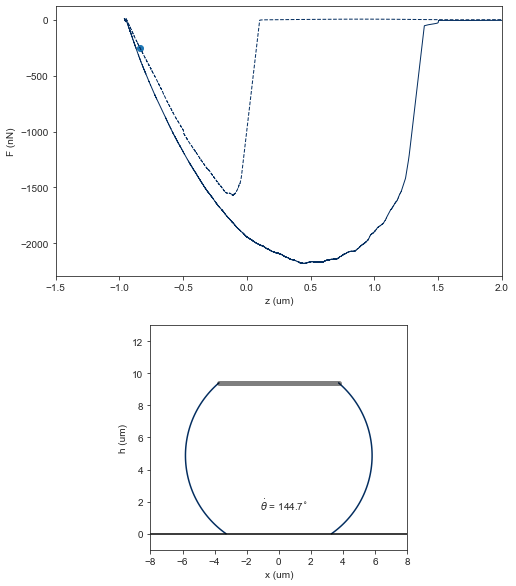

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(8,10), gridspec_kw={'height_ratios': [1.2, 1]})

i_point = 50000

H = (H_init+x1[i_point])*1e6 # Droplet height in um
F = y1[i_point] # Force in nN
print (H_init, H)

V = V_*1e15 # Droplet volume in pl
r = r_*1e6 # Contact size in um
gamma = 630. # Surface tension in mN/m


# Non-dimensionalized parameters
V_norm = V/r**3*1e3
H_norm = H/r
F_norm = -F/(r*gamma)

# guess values (non-dimensionalized)
dP = 1.0                       
r0 = 0.3
t0 = 140./180*np.pi

x_guess = np.array([r0, dP, t0])

# root-finding solver, look for solution m=0
x_opt = fsolve(m_res, x_guess, args=(H_norm, F_norm))
print (m_res(x_opt, H_norm, F_norm))

z_sol, u_sol, p_sol, V_sol, F_sol = calculate_sol(x_opt, H_norm)


ax[1].plot(u_sol*r, z_sol*r, color=color_b)
ax[1].plot(-u_sol*r, z_sol*r, color=color_b)

ax[1].plot([-40, 40], [0, 0], '-k') # plotting the base
ax[1].plot([-u_sol[-1]*r, u_sol[-1]*r], [H, H], '-k', alpha=0.5, lw=5)

ax[1].set_xlim([-8, 8])
ax[1].set_ylim([-1,13])
ax[1].set_xlabel("x (um)")
ax[1].set_ylabel("h (um)")

ax[1].set_aspect('equal')


#print out the fitted results
r_fit = x_opt[0]
P_fit = x_opt[1]
t_fit = x_opt[2]

ax[1].text(-1.2, 1.5, r"$\dot{\theta}$ = " + "{}".format(np.round(t_fit/np.pi*180,1))+r"$^{\circ}$")


print ("Contact size is {} um".format(np.round(2*r_fit*r,1)))
print ("Contact angle is {} deg".format(np.round(t_fit/np.pi*180,1)))
print ("Pressure inside droplet is {} kPa".format(np.round(P_fit*gamma/r,1)))

x_shift = 0.0
ax[0].plot(x1_approach-x_shift, y1_approach, color=color_b, lw=1, ls='--')
ax[0].plot(x1_retract-x_shift, y1_retract, color_b, lw=1, ls='-')
ax[0].set_xlim([-1.5, 2])

ax[0].scatter(x1[i_point]*1e6, y1[i_point])
ax[0].set_xlabel("z (um)")
ax[0].set_ylabel("F (nN)")